# Hierarchical Equal Risk Constribution Portfolio Optimization

Harry Markowitz's Modern Portfolio Theory (MPT) was seen as an amazing accomplishment in portfolio optimization, earning him a Nobel Prize for his work. MPT is based on the hypothesis that investors can optimize their portfolios based on a given level of risk. While this theory works very well mathematically, it fails to translate to real-world investing. This can be mainly attributed to two different reasons:
1. MPT involves the estimation of returns for a given set of assets. Although, accurately estimating returns for a set of assets is very difficult, in which small errors in estimation can cause sub-optimal performance.
2. MPT optimization methods involve the inversion of a covariance matrix for a set of assets. This matrix inversion leads the algorithm to be susceptible to market volatility and can heavily change the results for small changes in the correlations.

In 2016, Dr. Marcos Lopez de Prado introduced an alternative method for portfolio optimization, the Hierarchical Risk Parity (HRP) algorithm. This algorithm introduced the notion of hierarchy and can be computed in three main steps:
1. Hierarchical Clustering - breaks down our assets into hierarchical clusters
2. Quasi-Diagonalization - reorganizes the covariance matrix, placing similar assets together
3. Recursive Bisection - weights are assigned to each asset in our portfolio

This HRP algorithm laid the foundation for hierarchical clustering in asset allocation. In 2017, Thomas Raffinot built off this algorithm and this notion of hierarchy, building the Hierarchical Clustering Asset Allocation algorithm. This algorithm is computed in four main steps:
1. Hierarchical Clustering
2. Selecting the optimal number of clusters
3. Capital is allocated across clusters
4. Capital is allocated within clusters

However, in 2018, Raffinot developed the Hierarchical Equal Risk Contribution (HERC) algorithm, combining the machine learning approach of the HCAA algorithm with the recursive bisection approach from the HRP algorithm. The HERC algorithm aims to diversify capital and risk allocations throughout the portfolio and is computed in four main steps:
1. Hierarchical Clustering
2. Selecting the optimal number of clusters
3. Recursive Bisection
4. Implement Naive Risk Parity within clusters for weight allocations

Today, we will be exploring the HERC algorithm implemented through the MlFinLab library. **Please keep in mind that this a tutorial style post and we will be publishing a more theoretical article on the algorithm soon.**

## How HERC Portfolio Optimization Works?
In this section, we will go through each of the steps of the HERC algorithm, explaining them intuitively as well as implementing them in code in the next section.

### Hierarchical Clustering
Hierarchical clustering is used to place our assets into clusters suggested by the data and not by previously defined metrics. This ensures that the assets in a specific cluster maintain similarity. The objective of this step is to build a hierarchical tree in which our assets are all clustered on different levels. Conceptually, this may be difficult for some to understand, which is why we can visualize this tree through a dendrogram.

<img src='dendrogram.png'/>

The previous image shows the hierarchical clustering process results through a dendrogram. As the square containining our assets A-F showcases the similarity between each other, we can understand how the assets are clustered. Keep in mind that we are using agglomerative clustering, which assumes each data point to be an individual cluster at the start. 

First, the assets E and F are clustered together as they are the most similar. This is followed by the clustering of assets A and B. From this point, the clustering algorithm then includes asset D (and subsequently asset C) into the first clustering pair of assets E and F. Finally, the asset pair A and B is then clustered with the rest of the assets in the last step.

So you now may be asking, how does the algorithm know which assets to cluster together? Of course, we can visually see the distance between each asset, but our algorithm cannot. There are a few widely used methods for calculating the measure of distance/similarity within our algorithm: 
1. **Single Linkage** - the distance between two clusters it the minimum distance between any two points in the clusters
2. **Complete Linkage** - the distance between two clusters is the maximum of the distance between any two points in the clusters
3. **Average Linkage** - the distance between two clusters is the average of the distance between any two points in the clusters
4. **Ward Linkage** - the distance between two clusters is the increase of the squared error from when two clusters are merged

Thankfully, we can easily implement each linkage algorithm within the MlFinLab library, allowing us to quickly compare the results to each other.

### Selecting the Optimal Number of Clusters
Once our assets are all clustered in a hierarchical tree, we run into the problem of not knowing the optimal number of clusters for our weight allocations. We can use the Gap statistic for calculating our optimal number of clusters.

The Gap statistic is used as a measure for calculating our optimal number of clusters. It compares the total within intra-cluster variation for different values of k (with k being the number of clusters) with their expected values under null reference distribution of the data. Informally, this means that we should select the number of clusters which maximizes our Gap statistic before the rate of change begins to slow down. 

For example, in the following graph, the optimal number of clusters selected would be 6.

<img src='Gap_Statistics.png' />

At this stage in the algorithm, we have clustered all our assets into a hierarchical tree and selected the optimal number of clusters using the Gap statistic. We will now move onto recursive bisection.


### Recursive Bisection
In this step, portfolio weights for each of the tree clusters are calculated. Based on our dendrogram structure, the recursive bisection step recursively divides our tree following an Equal Risk Contribution allocation. An Equal Risk Contribution allocation makes sure that each asset contributes equally to the portfolio's volatility.

For example, consider a portfolio with asset allocations of 50% in stocks and 50% in bonds. While the asset allocation of this portfolio is equal with respect to our asset classes, our risk allocation is not. Depending on the nature of our stocks and bonds, our risk allocation for this portfolio can be near 90% portfolio risk in stocks and only 10% portfolio risk in bonds. By following an Equal Risk Contribution allocation method, this ensures that the recursive bisection step in our algorithm will distribute portfolio weights equally in terms of risk allocation and not in terms of asset allocation.

In the following image, we can see how recursive bisection splits the dendrogram by structure, and not based on assets. This is a key part of the HERC algorithm and is one of the reasons as to how HERC distinguishes itself from the HRP algorithm, in which HRP breaks down the tree based on the number of assets.

<img src='ex_dendo2.jpg' />

### Naive Risk Parity for Weight Allocations
Having calculated the cluster weights in the previous step, this step calculates the final asset weights. Within the same
cluster, an initial set of weights - $w_{NRP}$ - is calculated using the naive risk parity allocation. In this approach, assets are allocated weights in proportion to the inverse of their respective risk; higher risk assets will receive lower portfolio weights, and lower risk assets will receive higher weights. Here the risk can be quantified in different ways - variance, CVaR, CDaR, max daily loss etc...
The final weights are given by the following equation:

<p style="text-align: center;">
$w^{i}_{final} = w^{i}_{NRP} * C^{i}, \: i \in Clusters$
</p>

where, $w^{i}_{NRP}$ refers to naive risk parity weights of assets in the $i^{th}$ cluster and $C^{i}$ is the
weight of the  $i^{th}$ cluster calculated in Step-3.


## Application + Results

In this section, we will go through a working example of how we can implement the HERC algorithm through the MlFinLab library. First, we must load in our required libraries and our data.

In [3]:
# importing our required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mlfinlab.portfolio_optimization.hcaa import HierarchicalClusteringAssetAllocation

In this example, we will be working with historical closing-price data for 17 assets. The data we are working with was chosen because the clustering structure is clearly visible so it is a very good dataset for working with and visualizing various clustering techniques.

In [4]:
# reading in our data
raw_prices = pd.read_csv('assetalloc.csv', sep=';', parse_dates=True, index_col='Dates')
stock_prices = raw_prices.sort_values(by='Dates')
stock_prices.head()

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB
Dates,,,,,,,,,,,,,,,,,
1989-01-02,2039.7,875.47,297.09,392.50,99.081,99.039,99.572,100.000,100.031,100.345,101.080,101.936,154.38,117.50,1636.57,133.584,286.67
1989-01-03,2021.3,859.83,287.11,384.25,97.703,97.017,96.441,93.833,99.374,98.584,98.410,97.990,154.67,116.57,1696.35,142.080,286.00
1989-01-05,2118.0,900.64,309.12,378.25,98.253,99.113,99.275,97.634,99.715,99.561,99.965,99.950,164.29,127.22,1737.26,184.354,283.30
1989-01-06,2103.4,924.65,321.97,362.00,97.643,98.640,98.788,96.555,100.488,101.549,103.140,104.156,172.40,129.53,1724.29,187.731,279.96
1989-01-08,2292.3,1006.38,343.75,368.75,98.506,100.479,102.162,102.822,102.457,106.041,108.903,113.106,174.21,134.62,1775.39,173.067,277.31


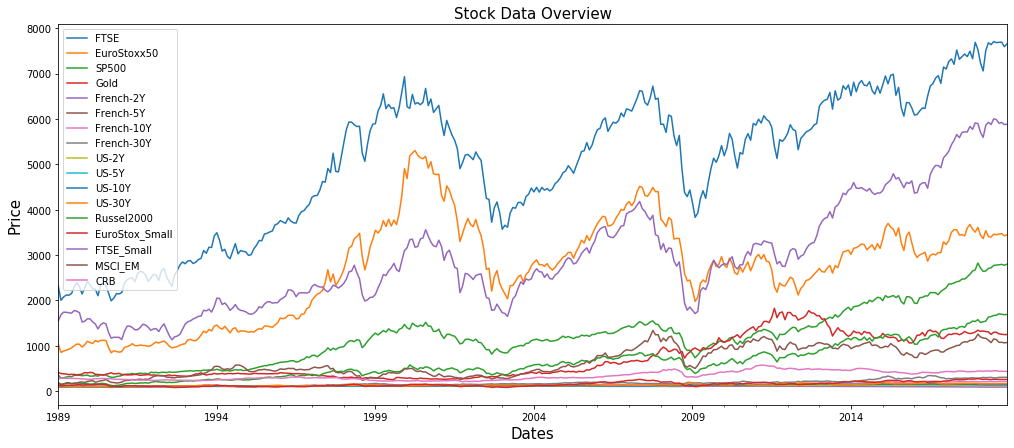

In [12]:
stock_prices.resample('M').last().plot(figsize=(17,7))
plt.ylabel('Price', size=15)
plt.xlabel('Dates', size=15)
plt.title('Stock Data Overview', size=15)
plt.show()

Now that we have our data loaded in, we can make use of the HierarchicalClusteringAssetAllocation class from MlFinLab to construct our optimized portfolio. First we must instantiate our class and then run the allocate() method to optimize our portfolio. 

**Keep in mind that MlFinLab currently supports the following metrics for calculating weight allocations:**
1. **'minimum_variance': The variance of the clusters is used as a risk metric**
2. **'minimum_standard_deviation': The standard deviation of the clusters is used as a risk metric**
3. **'sharpe_ratio': The Sharpe ratio of the clusters is used as a risk metric**
4. **'equal_weighting': All clusters are weighted equally with respect to the risk**
5. **'expected_shortfall': The expected shortfall of the clusters is used as a risk metric**
6. **'conditional_drawdown_risk': The conditional drawdown at risk of the clusters is used as a risk metric**

MlFinLab also supports all four linkage algorithms discussed in this post, though the default method is set as the Ward Linkage algorithm.

The allocate() method for the HierarchicalClusteringAssetAllocation object requires three parameters to run: 
1. asset_names (a list of strings containing the asset names)
2. asset_prices (a dataframe of historical asset prices - daily close)
3. allocation_metric (the type of solution/algorithm to use to calculate the weights - MlFinLab currently supports 6 different solutions)

Users can also specify: 
1. The type of linkage algorithm (shown below)
2. The confidence level used for calculating expected shortfall and conditional drawdown at risk 
3. The optimal number of clusters for clustering

For simplicity, we will only be working with the three required parameters and also specifying our linkage algorithm of choice. **In the example shown below, we are using an equal_weighting solution and the Ward Linkage algorithm.**

In [6]:
# HCAA implementation 
hcaa = HierarchicalClusteringAssetAllocation()
hcaa.allocate(asset_names=stock_prices.columns,
              asset_prices=stock_prices,
              allocation_metric='equal_weighting',
              linkage='ward')

print("HCAA (equal_weighting) Portfolio Weights - Ward Linkage \n", hcaa.weights)

HCAA (equal_weighting) Portfolio Weights - Ward Linkage 
      US-2Y    US-30Y     US-5Y  US-10Y  French-2Y  French-5Y  French-10Y  \
0  0.05909  0.032779  0.049577   0.125      0.125   0.085948    0.029841   

   French-30Y   MSCI_EM  FTSE_Small  EuroStoxx50  EuroStox_Small      FTSE  \
0    0.009211  0.198677    0.033676     0.013254        0.004393  0.032624   

      SP500  Russel2000      Gold    CRB  
0  0.028868    0.030509  0.016554  0.125  


Now that we can implement our HERC algorithm, lets see what happened behind the scenes of this implementation.

First the algorithm calculated our hierarchical tree, we can visualize the produced dendrogram through the plot_clusters() method.

In [ ]:
plt.figure(figsize=(17,7))
hcaa.plot_clusters(stock_prices.columns)
plt.title('HCAA Dendrogram', size=18)
plt.xticks(rotation=45)
plt.show()

<img src='hcaa_dendrogram.png' />

In this graph, the different colours in the x-labels represent the clusters that the stocks belong to. Through visual analysis, we can count that the optimal number of clusters determined by the Gap statistic is 6 for our dataset. We can also confirm this by printing out our optimal number of clusters through the 'optimal_num_clusters' attribute.

In [ ]:
print("Optimal Number of Clusters: " + str(hcaa.optimal_num_clusters))

6

Seeing what has happened behind the scenes allows us to better understand the intuition behind our algorithm. We can now visualize our final portfolio weights as a whole.

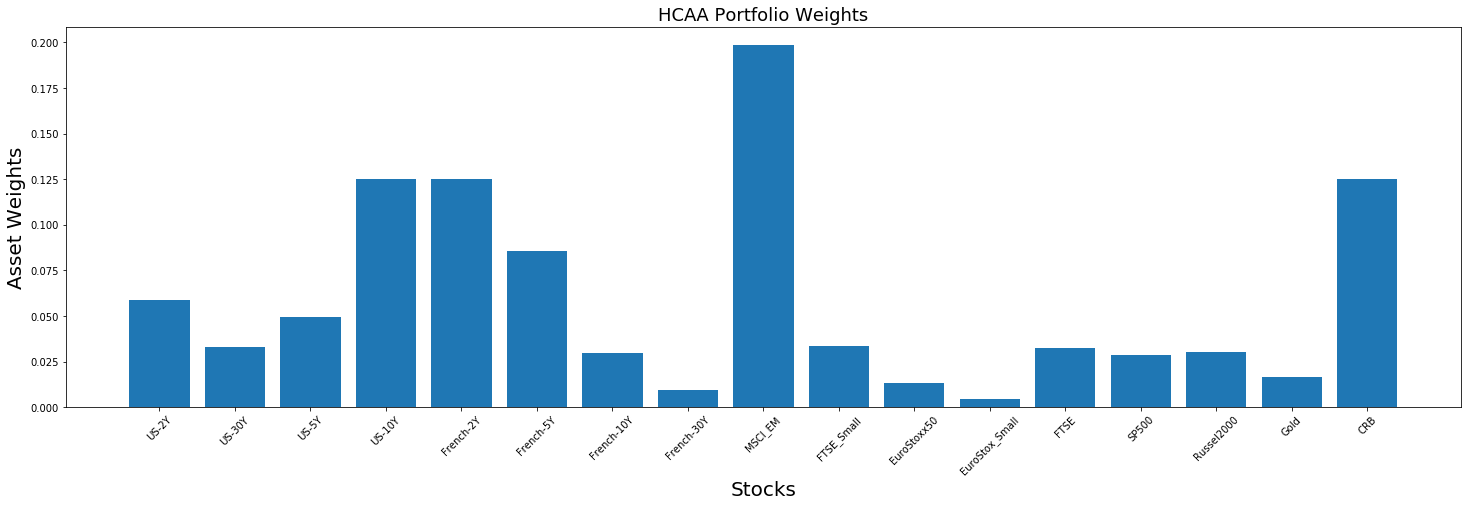

In [8]:
weights = hcaa.weights
weights = weights.values.tolist()
weights = [item for sublist in weights for item in sublist]
y_pos = np.arange(len(stock_prices.columns))

plt.figure(figsize=(25,7))
plt.bar(y_pos, weights)
plt.xticks(y_pos, hcaa.weights, rotation=45, size=10)
plt.xlabel('Stocks', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('HCAA Portfolio Weights', size=18)
plt.show()

This bar graph shows our different asset allocations for all assets in our portfolio.

### Using Custom input with MlFinLab
MlFinLab also provides users with a lot of customizability when it comes to creating their optimal portfolios. Instead of providing the raw historical closing prices for the assets, users can input the asset returns, a covariance matrix of asset returns, and expected asset returns to calculate their optimal portfolio.

The following parameters in the allocate() method are utilized in order to construct a custom use case:
1. 'asset_returns': (pd.DataFrame/NumPy matrix) A matrix of asset returns
2. 'covariance_matrix': (pd.DataFrame/NumPy matrix) A covariance matrix of asset returns
3. 'expected_asset_returns: (list) A list of mean asset returns

In this example of using custom input, we will be constructing the same optimized portfolio as the first example, utilizing an equal_weighting solution with the Ward Linkage algorithm. As we already know the optimal number of clusters, we will also be passing that in as a parameter to save on computation time.

To make some of the necessary calculations, we will make use of the ReturnsEstimation class provided by MlFinLab.

In [1]:
# importing ReturnsEstimation class from MlFinLab
from mlfinlab.portfolio_optimization.returns_estimators import ReturnsEstimation

In [5]:
# calculating our asset returns
returns = ReturnsEstimation.calculate_returns(stock_prices)
returns.head()

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB
Dates,,,,,,,,,,,,,,,,,
1989-01-03,-0.009021,-0.017865,-0.033593,-0.021019,-0.013908,-0.020416,-0.031445,-0.061670,-0.006568,-0.017549,-0.026415,-0.038711,0.001878,-0.007915,0.036528,0.063600,-0.002337
1989-01-05,0.047840,0.047463,0.076661,-0.015615,0.005629,0.021604,0.029386,0.040508,0.003431,0.009910,0.015801,0.020002,0.062197,0.091361,0.024116,0.297537,-0.009441
1989-01-06,-0.006893,0.026659,0.041570,-0.042961,-0.006208,-0.004772,-0.004906,-0.011051,0.007752,0.019968,0.031761,0.042081,0.049364,0.018158,-0.007466,0.018318,-0.011790
1989-01-08,0.089807,0.088390,0.067646,0.018646,0.008838,0.018644,0.034154,0.064906,0.019594,0.044235,0.055876,0.085929,0.010499,0.039296,0.029635,-0.078112,-0.009466
1989-01-09,0.050255,0.034281,0.029033,-0.026441,-0.004233,-0.006559,-0.006392,-0.014802,-0.014816,-0.025999,-0.029981,-0.036629,0.025831,0.048953,-0.004788,0.029382,-0.000288


In [6]:
# calculating our covariance matrix
cov = returns.cov()
cov

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB
FTSE,0.001792,0.002042,0.001628,0.000102,-0.000030,0.000012,0.000065,0.000097,-0.000043,-0.000090,-0.000113,-0.000201,0.001872,0.001904,0.001928,0.002283,0.000461
EuroStoxx50,0.002042,0.003230,0.002128,-0.000039,-0.000053,-0.000037,0.000013,0.000037,-0.000093,-0.000210,-0.000283,-0.000444,0.002436,0.002977,0.002567,0.002999,0.000564
SP500,0.001628,0.002128,0.002135,0.000055,-0.000058,-0.000010,0.000046,0.000035,-0.000038,-0.000085,-0.000109,-0.000231,0.002265,0.001967,0.001961,0.002508,0.000598
Gold,0.000102,-0.000039,0.000055,0.001774,-0.000011,0.000012,0.000024,0.000021,0.000026,0.000082,0.000113,0.000104,0.000125,0.000246,0.000183,0.001070,0.000501
French-2Y,-0.000030,-0.000053,-0.000058,-0.000011,0.000025,0.000037,0.000042,0.000058,0.000011,0.000024,0.000034,0.000053,-0.000066,-0.000081,-0.000067,-0.000093,-0.000048
French-5Y,0.000012,-0.000037,-0.000010,0.000012,0.000037,0.000111,0.000171,0.000262,0.000030,0.000079,0.000129,0.000209,-0.000037,-0.000085,-0.000050,-0.000111,-0.000076
French-10Y,0.000065,0.000013,0.000046,0.000024,0.000042,0.000171,0.000319,0.000530,0.000047,0.000137,0.000244,0.000423,-0.000003,-0.000049,-0.000027,-0.000121,-0.000117
French-30Y,0.000097,0.000037,0.000035,0.000021,0.000058,0.000262,0.000530,0.001034,0.000072,0.000228,0.000427,0.000795,-0.000036,-0.000072,-0.000090,-0.000278,-0.000248
US-2Y,-0.000043,-0.000093,-0.000038,0.000026,0.000011,0.000030,0.000047,0.000072,0.000028,0.000062,0.000084,0.000115,-0.000065,-0.000120,-0.000108,-0.000100,-0.000036
US-5Y,-0.000090,-0.000210,-0.000085,0.000082,0.000024,0.000079,0.000137,0.000228,0.000062,0.000165,0.000249,0.000371,-0.000169,-0.000273,-0.000243,-0.000244,-0.000102


In [7]:
# calculating our mean asset returns
mean_returns = ReturnsEstimation.calculate_mean_historical_returns(stock_prices)
mean_returns

FTSE              0.264280
EuroStoxx50       0.433313
SP500             0.335210
Gold              0.260800
French-2Y        -0.000044
French-5Y         0.027392
French-10Y        0.064993
French-30Y        0.167084
US-2Y             0.010230
US-5Y             0.032652
US-10Y            0.064161
US-30Y            0.174726
Russel2000        0.481756
EuroStox_Small    0.460265
FTSE_Small        0.449934
MSCI_EM           0.792658
CRB               0.143230
dtype: float64

In [9]:
# from here, we can now create our portfolio
hcaa_custom = HierarchicalClusteringAssetAllocation()
hcaa_custom.allocate(asset_names=stock_prices.columns,
                        asset_returns=returns,
                        covariance_matrix=cov, 
                        allocation_metric='equal_weighting',
                        linkage='ward',
                        optimal_num_clusters=6)

print("Custom HCAA Portfolio - Equal Weighting \n", hcaa_custom.weights)

Custom HCAA Portfolio - Equal Weighting 
      US-2Y    US-30Y     US-5Y  US-10Y  French-2Y  French-5Y  French-10Y  \
0  0.05909  0.032779  0.049577   0.125      0.125   0.085948    0.029841   

   French-30Y   MSCI_EM  FTSE_Small  EuroStoxx50  EuroStox_Small      FTSE  \
0    0.009211  0.198677    0.033676     0.013254        0.004393  0.032624   

      SP500  Russel2000      Gold    CRB  
0  0.028868    0.030509  0.016554  0.125  


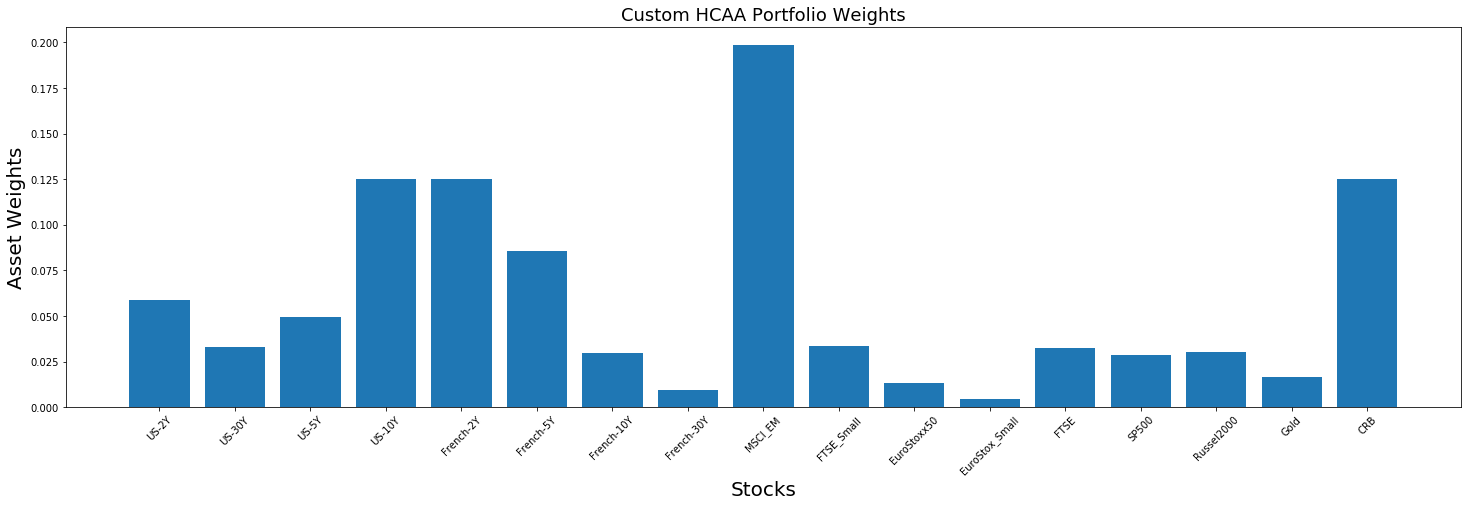

In [10]:
# plotting our custom portfolio
custom_weights = hcaa_custom.weights
custom_weights = custom_weights.values.tolist()
custom_weights = [item for sublist in custom_weights for item in sublist]
y_pos = np.arange(len(stock_prices.columns))

plt.figure(figsize=(25,7))
plt.bar(y_pos, custom_weights)
plt.xticks(y_pos, hcaa_custom.weights, rotation=45, size=10)
plt.xlabel('Stocks', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('Custom HCAA Portfolio Weights', size=18)
plt.show()

As we can see through these examples, implementing the HCAA algorithm through MlFinLab can be done very easily to provide high-quality results.

## Conclusion
Through this post, we learned the intuition behind Thomas Raffinot's Hierarchical Equal Risk Contribution portfolio optimization algorithm. We also saw how we can utilize the MlFinLab library to effortlessy apply this technique in custom situations. HERC is a powerful algorithm that can produce robust portfolios which avoids many of the problems seen with Modern Portfolio Theory.  

If you would like to play around with some of the code in this article, check out our tutorial notebook dedicated to the HCAA algorithm! The notebook is stored in Hudson & Thames' research repository on Github under the 'Portfolio Optimisation Tutorials' folder!